In [14]:
import pandas as pd
import numpy as np
from   sklearn.model_selection import train_test_split
from   sklearn.metrics import accuracy_score
from   sklearn.preprocessing import StandardScaler
from   sklearn import svm
from   sklearn.svm import SVC
from   sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from joblib import load
import os 
from collections import Counter 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score
from pycaret.clustering import setup, create_model, assign_model, plot_model


In [15]:
dfs = []

base_path = "C:\\classificador-de-padroes-de-mobilidade\\dataset\\raw\\Dataset-FallWatch"
for i in range(1,6):
    folder_name_avd = f"U{i:02d}\\AVD's"
    folder_name_fall = f"U{i:02d}\\Falls"
    
    folder_path_avd = os.path.join(base_path, folder_name_avd)
    folder_path_fall = os.path.join(base_path, folder_name_fall)
    
    for j in range(1, 12):
        file_name_avd = f'U{i:02d} - D{j:02d}.csv'
        file_path_avd = os.path.join(folder_path_avd, file_name_avd)
        
        file_name_fall = f'U{i:02d} - F{j:02d}.csv'
        file_path_fall = os.path.join(folder_path_fall, file_name_fall)
        
        if os.path.exists(file_path_avd):
            dataframe_teste = pd.read_csv(file_path_avd)
            dataframe_teste['idUsuario'] = f'U{i:02d}'
            dataframe_teste['idTipoMovimento'] = f'D{j:02d}'
            dfs.append(dataframe_teste)
            
        if os.path.exists(file_path_fall):
            dataframe_teste = pd.read_csv(file_path_fall)
            dataframe_teste['idUsuario'] = f'U{i:02d}'
            dataframe_teste['idTipoMovimento'] = f'F{j:02d}'
            dfs.append(dataframe_teste)

dataframe_teste = pd.concat(dfs, ignore_index=True)

movimentos_formatados = {"D01":"Caminhando",
"D02":"Correndo",
# "D03":"Subindo e descendo escadas", nao possui no dataset
"D04":"Sentando em uma cadeira, esperar um momento e levantar-se",
"D05":"Sentado por um momento, tentar levantar-se e cair na cadeira",
"D06":"Agachando (dobrando os joelhos), amarrar sapatos e levantar-se",
"D07":"Tropeçar enquanto caminha",
"D08":"Pular suavemente sem cair(tentando alcançar um objeto)",
"D09":"Bater na mesa com a mão",
"D10":"Batendo palmas",
"F01":"Queda para frente ao caminhar causada por escorregão",
"F02":"Queda lateral ao caminhar causada por escorregão",
"F03":"Queda para trás ao caminhar causada por escorregão",
"F04":"Queda para frente ao caminhar causada por tropeço",
"F05":"Queda para trás ao tentar sentar-se",
"F06":"Queda para frente enquanto sentado, causada por desmaio ou adormecimento",
"F07":"Queda para trás enquanto sentado, causada por desmaio ou adormecimento",
"F08":"Queda lateral enquanto sentado, causada por desmaio ou adormecimento",
}

colunas_selecionadas = ['tempo','idUsuario','acelX', 'acelY', 'acelZ' ,'idTipoMovimento']
dataframe_teste = dataframe_teste[colunas_selecionadas]
dataframe_teste['MAGNITUDE_ACEL']   = np.sqrt(dataframe_teste['acelX']**2 + dataframe_teste['acelY']**2 + dataframe_teste['acelZ']**2)
dataframe_teste = dataframe_teste[dataframe_teste['idTipoMovimento'].isin(['D04'])]
dataframe_teste = dataframe_teste[dataframe_teste['idUsuario'].isin(['U04'])]
dataframe_teste = dataframe_teste[['tempo','acelX', 'acelY', 'acelZ' ,'idTipoMovimento','MAGNITUDE_ACEL']]
dataframe_teste = dataframe_teste.reset_index(drop=True)
dataframe_teste


,tempo,acelX,acelY,acelZ,idTipoMovimento,MAGNITUDE_ACEL
0,0,-699.0,-1804.0,-155.0,D04,1940.886911
1,40,-708.0,-1772.0,-144.0,D04,1913.631103
2,80,-723.0,-1762.0,-142.0,D04,1909.852612
3,120,-736.0,-1792.0,-158.0,D04,1943.688247
4,160,-720.0,-1793.0,-192.0,D04,1941.677883
...,...,...,...,...,...,...
496,19840,-878.0,-1725.0,-147.0,D04,1941.164084
497,19880,-877.0,-1721.0,-147.0,D04,1937.157454
498,19920,-883.0,-1718.0,-150.0,D04,1937.450128
499,19960,-882.0,-1724.0,-143.0,D04,1941.790153


<function matplotlib.pyplot.show(close=None, block=None)>

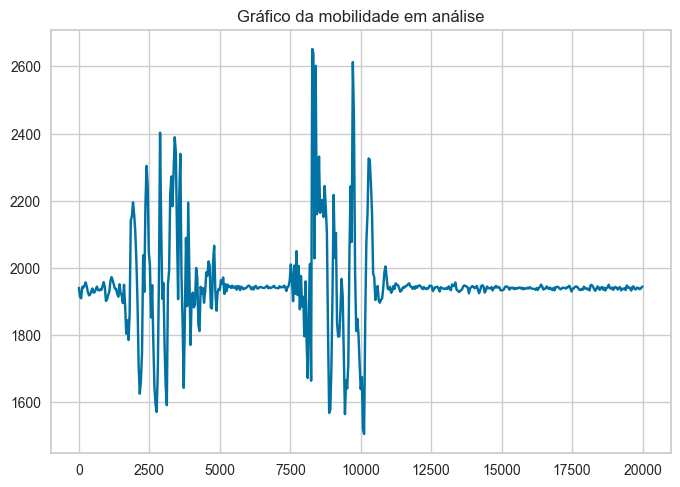

In [16]:
# Gráfico da mobilidade em análise
plt.title("Gráfico da mobilidade em análise")
plt.plot(dataframe_teste['tempo'], dataframe_teste['MAGNITUDE_ACEL'])
plt.show

In [17]:
# Parâmetros
intervalo_amostras = 10  # número de amostras por segmento (400ms)

# Inicializar listas para armazenar os resultados
medias_mag = []
maximas_mag = []
minimas_mag = []
dados_segmentos = []

# Analisar segmentos com janela deslizante
for i in range(len(dataframe_teste) - intervalo_amostras + 1):
    segmento = dataframe_teste.iloc[i:i + intervalo_amostras]

    media_x = segmento['acelX'].mean()
    media_y = segmento['acelY'].mean()
    media_z = segmento['acelZ'].mean()
    media_mag = segmento['MAGNITUDE_ACEL'].mean()
    
    max_x = segmento['acelX'].max()
    max_y = segmento['acelY'].max()
    max_z = segmento['acelZ'].max()
    max_mag = segmento['MAGNITUDE_ACEL'].max()
    
    min_x = segmento['acelX'].min()
    min_y = segmento['acelY'].min()
    min_z = segmento['acelZ'].min()
    min_mag = segmento['MAGNITUDE_ACEL'].min()
    
    # Pegando o idTipoMovimento e o Cluster Processado para o segmento
    id_tipo_movimento = segmento['idTipoMovimento'].iloc[0]
    # cluster_processado = segmento['Cluster Processado'].iloc[0]

    # Adicionando as métricas à lista
    medias_mag.append(media_mag)
    maximas_mag.append(max_mag)
    minimas_mag.append(min_mag)

    # Adicionando os dados do segmento à lista de dados
    dados_segmentos.append({
        'seg': i + 1,
        'idTipoMovimento': id_tipo_movimento,
        # 'Cluster Processado': cluster_processado,
        'med_x': media_x,
        'med_y': media_y,
        'med_z': media_z,
        'med_mag': media_mag,
        'max_x': max_x,
        'max_y': max_y,
        'max_z': max_z,
        'max_mag': max_mag,
        'min_x': min_x,
        'min_y': min_y,
        'min_z': min_z,
        'min_mag': min_mag
    })

# Criar um DataFrame com os dados dos segmentos
df_segmentos = pd.DataFrame(dados_segmentos)

# Calcular diferenças entre segmentos consecutivos para a magnitude_acel
media_difs_mag = np.diff(medias_mag)
maxima_difs_mag = np.diff(maximas_mag)
minima_difs_mag = np.diff(minimas_mag)

# Calcular desvios padrão das diferenças
media_dif_std = np.std(media_difs_mag)
maxima_dif_std = np.std(maxima_difs_mag)
minima_dif_std = np.std(minima_difs_mag)

# Adicionar as diferenças ao DataFrame de segmentos
df_segmentos['media_dif'] = [None] + list(media_difs_mag)
df_segmentos['maxima_dif'] = [None] + list(maxima_difs_mag)
df_segmentos['minima_dif'] = [None] + list(minima_difs_mag)

# Exibir o DataFrame resultante
df_segmentos = df_segmentos.drop(columns=['seg','idTipoMovimento'])
# Remover linhas com NaNs
df_segmentos = df_segmentos.dropna()
df_segmentos


,med_x,med_y,med_z,med_mag,max_x,max_y,max_z,max_mag,min_x,min_y,min_z,min_mag,media_dif,maxima_dif,minima_dif
1,-707.4,-1790.6,-165.7,1932.560440,-679.0,-1762.0,-142.0,1956.997956,-736.0,-1811.0,-201.0,1909.852612,-1.991762,0.000000,0.000000
2,-706.1,-1792.7,-168.9,1934.299634,-679.0,-1762.0,-142.0,1956.997956,-736.0,-1811.0,-201.0,1909.852612,1.739194,0.000000,0.000000
3,-703.5,-1796.5,-173.1,1937.212929,-679.0,-1785.0,-148.0,1956.997956,-736.0,-1811.0,-201.0,1918.313061,2.913295,0.000000,8.460449
4,-700.0,-1795.9,-174.7,1935.495941,-679.0,-1785.0,-148.0,1956.997956,-720.0,-1811.0,-201.0,1918.313061,-1.716988,0.000000,0.000000
5,-699.4,-1794.9,-172.2,1934.117519,-679.0,-1783.0,-148.0,1956.997956,-718.0,-1811.0,-201.0,1918.313061,-1.378421,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,-879.7,-1723.1,-143.3,1939.976361,-876.0,-1717.0,-133.0,1945.112079,-883.0,-1728.0,-149.0,1932.631626,-0.677303,-2.825035,0.000000
488,-879.7,-1722.6,-143.1,1939.516773,-876.0,-1717.0,-133.0,1945.112079,-883.0,-1728.0,-147.0,1932.631626,-0.459588,0.000000,0.000000
489,-879.8,-1721.9,-143.8,1938.993981,-876.0,-1717.0,-133.0,1945.112079,-883.0,-1728.0,-150.0,1932.631626,-0.522792,0.000000,0.000000
490,-880.1,-1722.0,-144.8,1939.290068,-876.0,-1717.0,-140.0,1945.112079,-883.0,-1728.0,-150.0,1932.631626,0.296087,0.000000,0.000000


In [25]:
with open('svm_model.joblib', 'rb') as file:
    svm_loaded = load(file)
    
X_test = df_segmentos

y_pred = svm_loaded.predict(X_test)
len(y_pred)

491